In [1]:
from __future__ import absolute_import
from __future__ import print_function
import numpy as np

import random
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, Lambda
from keras.optimizers import RMSprop
from keras import backend as K
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
num_classes = 10
epochs = 20


def euclidean_distance(vects):
    x, y = vects
    sum_square = K.sum(K.square(x - y), axis=1, keepdims=True)
    return K.sqrt(K.maximum(sum_square, K.epsilon()))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)


def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    sqaure_pred = K.square(y_pred)
    margin_square = K.square(K.maximum(margin - y_pred, 0))
    return K.mean(y_true * sqaure_pred + (1 - y_true) * margin_square)

# 트레이닝 데이터, 각 숫자 클래스별의 index를 갖고있는 [numpy.array]
def create_pairs(x, digit_indices):
    '''Positive and negative pair creation.
    Alternates between positive and negative pairs.
    '''
    pairs = []
    labels = []
    n = min([len(digit_indices[d]) for d in range(num_classes)]) - 1
    for d in range(num_classes):
        for i in range(n):
            z1, z2 = digit_indices[d][i], digit_indices[d][i + 1]
            pairs += [[x[z1], x[z2]]]
            inc = random.randrange(1, num_classes)
            dn = (d + inc) % num_classes
            z1, z2 = digit_indices[d][i], digit_indices[dn][i]
            pairs += [[x[z1], x[z2]]]
            labels += [1, 0]
    return np.array(pairs), np.array(labels)


def create_base_network(input_shape):
    '''Base network to be shared (eq. to feature extraction).
    '''
    input = Input(shape=input_shape)
    x = Flatten()(input)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.1)(x)
    x = Dense(128, activation='relu')(x)
    return Model(input, x)


def compute_accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    pred = y_pred.ravel() < 0.5
    return np.mean(pred == y_true)


def accuracy(y_true, y_pred):
    '''Compute classification accuracy with a fixed threshold on distances.
    '''
    return K.mean(K.equal(y_true, K.cast(y_pred < 0.5, y_true.dtype)))


In [7]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
# (28, 28)
input_shape = x_train.shape[1:]

# create training+test positive and negative pairs
# 각 숫자들의 class별의 index별로 모아둔 list
digit_indices = [np.where(y_train == i)[0] for i in range(num_classes)]
tr_pairs, tr_y = create_pairs(x_train, digit_indices)

digit_indices = [np.where(y_test == i)[0] for i in range(num_classes)]
te_pairs, te_y = create_pairs(x_test, digit_indices)

In [29]:
tr_pairs.shape

(2000, 2, 28, 28)

In [30]:
tr_y.shape

(2000,)

In [27]:
x_train.shape

(60000, 28, 28)

In [25]:
np.where(y_train == 0)[0]

array([    1,    21,    34, ..., 59952, 59972, 59987], dtype=int64)

In [17]:
x_train.shape[]

(28, 28)

In [8]:
tr_pairs = tr_pairs[:2000]
tr_y = tr_y[:2000]
te_pairs = te_pairs[:500]
te_y = te_y[:500]

In [9]:
type(tr_pairs[:,1])

numpy.ndarray

In [72]:
type(tr_pairs)

numpy.ndarray

In [66]:
tr_pairs.shape

(108400, 2, 28, 28)

In [65]:
te_pairs.shape

(17820, 2, 28, 28)

In [19]:
y_train[5]

2

In [21]:
x_train.shape

(60000, 28, 28)

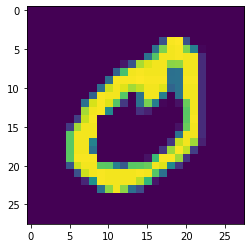

In [40]:
plt.imshow(tr_pairs[0][1])

In [47]:
tr_y.shape

(108400,)

In [58]:
tr_y

array([1, 0, 1, ..., 0, 1, 0])

In [46]:
tr_pairs.shape

(108400, 2, 28, 28)

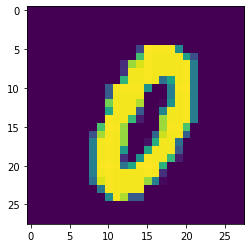

In [64]:
plt.imshow(tr_pairs[2][1])

In [45]:
tr_y[1]

0

In [32]:
np.where(y_train == 1)[0]

array([    3,     6,     8, ..., 59979, 59984, 59994], dtype=int64)

In [20]:
tr_pairs.shape

(108400, 2, 28, 28)

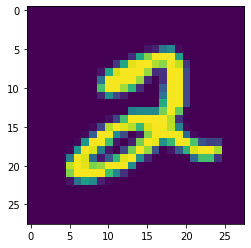

In [17]:
plt.imshow(x_train[5])

In [34]:
distance

<tf.Tensor 'lambda_1/Sqrt:0' shape=(?, 1) dtype=float32>

In [36]:
print(f'input_a  : {input_a}')
print(f'input_b  : {input_b}')
print(f'processed_a  : {processed_a}')
print(f'processed_b  : {processed_b}')
print(f'distance  : {distance}')

input_a  : Tensor("input_2:0", shape=(?, 28, 28), dtype=float32)
input_b  : Tensor("input_3:0", shape=(?, 28, 28), dtype=float32)
processed_a  : Tensor("model_1/dense_3/Relu:0", shape=(?, 128), dtype=float32)
processed_b  : Tensor("model_1_1/dense_3/Relu:0", shape=(?, 128), dtype=float32)
distance  : Tensor("lambda_1/Sqrt:0", shape=(?, 1), dtype=float32)


In [10]:

# network definition
base_network = create_base_network(input_shape)

input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

distance = Lambda(euclidean_distance,
                  output_shape=eucl_dist_output_shape)([processed_a, processed_b])

model = Model([input_a, input_b], distance)

# train
rms = RMSprop()
model.compile(loss=contrastive_loss, optimizer=rms, metrics=[accuracy])


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [11]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 28, 28)       0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 128)          133504      input_2[0][0]                    
                                                                 input_3[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 1)            0           model_1[1][0]                    
          

In [12]:
model.fit([tr_pairs[:, 0], tr_pairs[:, 1]], tr_y,
          batch_size=2,
          epochs=5,
          validation_data=([te_pairs[:, 0], te_pairs[:, 1]], te_y))


Instructions for updating:
Use tf.cast instead.
Train on 2000 samples, validate on 500 samples
Epoch 1/5
2000/2000 [==============================] - 12s 6ms/step - loss: 0.0497 - accuracy: 0.9465 - val_loss: 0.0357 - val_accuracy: 0.9700
Epoch 2/5
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0136 - accuracy: 0.9855 - val_loss: 0.0249 - val_accuracy: 0.9740
Epoch 3/5
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0093 - accuracy: 0.9910 - val_loss: 0.0235 - val_accuracy: 0.9740
Epoch 4/5
2000/2000 [==============================] - 6s 3ms/step - loss: 0.0034 - accuracy: 0.9940 - val_loss: 0.0226 - val_accuracy: 0.9780
Epoch 5/5
2000/2000 [==============================] - 7s 3ms/step - loss: 0.0032 - accuracy: 0.9965 - val_loss: 0.0163 - val_accuracy: 0.9780


In [ ]:
# compute final accuracy on training and test sets
y_pred = model.predict([tr_pairs[:, 0], tr_pairs[:, 1]])
tr_acc = compute_accuracy(tr_y, y_pred)
y_pred = model.predict([te_pairs[:, 0], te_pairs[:, 1]])
te_acc = compute_accuracy(te_y, y_pred)

print('* Accuracy on training set: %0.2f%%' % (100 * tr_acc))
print('* Accuracy on test set: %0.2f%%' % (100 * te_acc))